В этом блокноте мы пытаемся найти зону Вернике на фМРТ. Парадигма была составлена из трех типов слуховых стимулов, которые начитывал безэмоциональный робот: слова, предложения и бессвязные фонемы. 

Анализ производится посредством nipype -- библиотеки для Питона, представляющей собой общий уберинтерфейс над SPM, FSL, AFNI и другими программами. Пока что из всего этого разнообразия мы используем только методы SPM. 

In [1]:
import os
import time
import subprocess
import numpy as np
import matplotlib.pyplot as plt

import nibabel as nib

from nipype import Node
from nipype.interfaces import spm

import nilearn as nl
from nilearn.plotting import plot_glass_brain, view_img

np.set_printoptions(precision=3, suppress=True)

start_time = time.time()

201121-15:51:05,954 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0-rc1.post-dev


Так как нам нужен SPM, сначала определяем папки, где лежат MATLAB Common Runtime и SPM. 

In [2]:
matlab_cmd = '/opt/spm12-r7219/run_spm12.sh /opt/matlabmcr-2010a/v713/ script'
spm.SPMCommand.set_mlab_paths(matlab_cmd=matlab_cmd, use_mcr=True)

In [3]:
base_dir = subprocess.check_output('pwd').decode()[:-1]
base_dir

'/home/neuro/nipype_tutorial/fmri_handling/Wernicke'

Получаем списки DICOM-файлов, с которыми будем дальше работать. 

In [4]:
t1_files = [base_dir + '/t1_dicom/'+ i for i in os.listdir('t1_dicom') if i.endswith('dcm')]

fmri_files = [base_dir + '/fmri_dicom/'+ i for i in os.listdir('fmri_dicom') if i.endswith('dcm')]

In [5]:
t1_files[:5]

['/home/neuro/nipype_tutorial/fmri_handling/Wernicke/t1_dicom/IMG-0001-00001.dcm',
 '/home/neuro/nipype_tutorial/fmri_handling/Wernicke/t1_dicom/IMG-0001-00002.dcm',
 '/home/neuro/nipype_tutorial/fmri_handling/Wernicke/t1_dicom/IMG-0001-00003.dcm',
 '/home/neuro/nipype_tutorial/fmri_handling/Wernicke/t1_dicom/IMG-0001-00004.dcm',
 '/home/neuro/nipype_tutorial/fmri_handling/Wernicke/t1_dicom/IMG-0001-00005.dcm']

In [6]:
fmri_files[:5]

['/home/neuro/nipype_tutorial/fmri_handling/Wernicke/fmri_dicom/IMG-0001-00001.dcm',
 '/home/neuro/nipype_tutorial/fmri_handling/Wernicke/fmri_dicom/IMG-0001-00002.dcm',
 '/home/neuro/nipype_tutorial/fmri_handling/Wernicke/fmri_dicom/IMG-0001-00003.dcm',
 '/home/neuro/nipype_tutorial/fmri_handling/Wernicke/fmri_dicom/IMG-0001-00004.dcm',
 '/home/neuro/nipype_tutorial/fmri_handling/Wernicke/fmri_dicom/IMG-0001-00005.dcm']

Перегоняем DICOM в NIfTI. Сначала Т1 (готовый .nii-файл пишется в папку с этим блокнотом). 

In [7]:
t1_import = Node(spm.DicomImport(), name='t1_conversion')
t1_import.overwrite = False
t1_import.inputs.in_files = t1_files
t1_import.inputs.output_dir = base_dir

In [8]:
t1_import_res = t1_import.run()

201121-15:51:09,811 nipype.workflow INFO:
	 [Node] Setting-up "t1_conversion" in "/tmp/tmpj5wdhh3j/t1_conversion".
201121-15:51:11,283 nipype.workflow INFO:
	 [Node] Running "t1_conversion" ("nipype.interfaces.spm.utils.DicomImport")
201121-15:51:32,97 nipype.workflow INFO:
	 [Node] Finished "t1_conversion".


Потом EPI (готовые объемы пишутся в папку `f`). 

In [9]:
fmri_import = Node(spm.DicomImport(), name='fmri_conversion')
fmri_import.overwrite = False
fmri_import.inputs.in_files = fmri_files
fmri_import.inputs.output_dir = base_dir + '/f'

In [10]:
%%time
fmri_import_res = fmri_import.run()

201121-15:51:41,629 nipype.workflow INFO:
	 [Node] Setting-up "fmri_conversion" in "/tmp/tmp7u07b9l8/fmri_conversion".
201121-15:52:38,283 nipype.workflow INFO:
	 [Node] Running "fmri_conversion" ("nipype.interfaces.spm.utils.DicomImport")
201121-15:59:30,30 nipype.workflow INFO:
	 [Node] Finished "fmri_conversion".
CPU times: user 5.19 s, sys: 7.1 s, total: 12.3 s
Wall time: 7min 48s


Тут начинается препроцессинг. Первые десять объемов выкидываем. Оставшиеся 120 подвергаются motion correction по отношению к их среднему арифметическому. 

In [11]:
realign = Node(spm.Realign(), name='realign_node')
realign.inputs.register_to_mean = True
realign.inputs.in_files = ['f/' + i for i in os.listdir('f')][10:] #Возможный инпут: fmri_import_res.outputs.out_files[10:]

In [12]:
realign_res = realign.run()

201121-15:59:30,290 nipype.workflow INFO:
	 [Node] Setting-up "realign_node" in "/tmp/tmp2w3kj5fq/realign_node".
201121-15:59:34,778 nipype.workflow INFO:
	 [Node] Running "realign_node" ("nipype.interfaces.spm.preprocess.Realign")
201121-16:00:55,648 nipype.workflow INFO:
	 [Node] Finished "realign_node".


Получившиеся файлы сглаживаются. 

In [13]:
smooth = Node(spm.Smooth(), name='smooth')
smooth.base_dir = base_dir
smooth.inputs.fwhm = [8, 8, 8]
smooth.inputs.in_files = realign_res.outputs.realigned_files

In [14]:
smooth_res = smooth.run()

201121-16:00:55,672 nipype.workflow INFO:
	 [Node] Setting-up "smooth" in "/home/neuro/nipype_tutorial/fmri_handling/Wernicke/smooth".
201121-16:00:55,685 nipype.workflow INFO:
	 [Node] Outdated cache found for "smooth".
201121-16:00:56,358 nipype.workflow INFO:
	 [Node] Running "smooth" ("nipype.interfaces.spm.preprocess.Smooth")
201121-16:01:56,157 nipype.workflow INFO:
	 [Node] Finished "smooth".


In [15]:
print("Все произошло за %.2f минуты." % ((time.time() - start_time)/60))

Все произошло за 10.82 минуты.


Довольно долго, но это у меня на ноуте. На рабочем компе быстрее.

Здесь мы используем корегистрацию в режиме estimate, а не estimate and reslice. Дело в том, что в режиме estimate происходит исправление матрицы affine в метаданных файла Т1, а во втором случае еще и генерится скорректированный файл Т1 с размерностью, пониженной до размерности функциональных объемов. Этого нам не нужно, мы сгенерируем правильный Т1 сами, и сделаем это без даунсемплинга. 

In [16]:
t1_raw = nib.load('sGIS060691-0003-00001-000001-01.nii')

In [17]:
coregistration = spm.Coregister()
coregistration.inputs.jobtype = 'estimate'
coregistration.inputs.target = realign_res.outputs.modified_in_files[0]
coregistration.inputs.source = 'sGIS060691-0003-00001-000001-01.nii'
coregistration_res = coregistration.run()

In [18]:
coregistration_res.outputs


coregistered_files = <undefined>
coregistered_source = sGIS060691-0003-00001-000001-01.nii

Корегистрация прошла, метаданные исправлены. 

In [19]:
t1_affine_corrected = nib.load('sGIS060691-0003-00001-000001-01.nii')
t1_affine_corrected_array = t1_affine_corrected.get_fdata()

In [20]:
t1_raw.shape

(256, 256, 170)

In [21]:
print(t1_raw.affine)
print(t1_affine_corrected.affine)

[[   0.       0.       1.     -85.375]
 [  -1.       0.       0.     170.928]
 [   0.       1.       0.    -169.392]
 [   0.       0.       0.       1.   ]]
[[   0.032    0.022    0.999  -92.053]
 [  -0.999   -0.034    0.033  171.787]
 [  -0.035    0.999   -0.021 -164.72 ]
 [   0.       0.       0.       1.   ]]


Как видите, матрица аффинного преобразования из воксельного пространства в реальное -- поменялась. 

In [22]:
t1_resampled = nl.image.resample_img(t1_affine_corrected, target_affine=t1_raw.affine, target_shape=t1_raw.shape)
t1_resampled_array = t1_resampled.get_fdata()
nib.save(t1_resampled, 't1_resampled.nii')

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


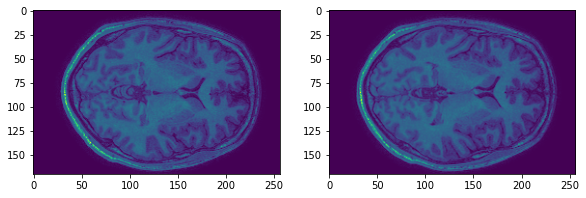

In [23]:
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(t1_affine_corrected_array[::-1,130,::].T)
plt.subplot(132)
plt.imshow(t1_resampled_array[::-1,130,::].T)

Поэтому срезы на одном уровне немного отличаются. 

Тут, короче, я задаю парадигму, которую мы использовали. Прописываем два контраста: один -- слова, другой -- предложения. Бессмысленные фонемы использутся как фон. 

In [24]:
from nipype.algorithms import modelgen
from nipype.interfaces.base import Bunch

In [25]:
model = modelgen.SpecifyModel()

model.inputs.input_units = 'secs'
model.inputs.functional_runs = [['smooth/' + i for i in os.listdir('smooth/') if i.endswith('.nii')]]

model.inputs.time_repetition = 25
model.inputs.high_pass_filter_cutoff = 128

In [26]:
evs_run = Bunch(conditions=['words', 'sentences'], 
                onsets=[[0, 125, 200, 275], [25, 75, 175, 225]], 
                durations=[[25, 25, 25, 25], [25, 25, 25, 25]])
model.inputs.subject_info = [evs_run]

In [27]:
model_results = model.run()

In [28]:
model_results.outputs.session_info

[{'cond': [{'name': 'words',
    'onset': [0.0, 125.0, 200.0, 275.0],
    'duration': [25.0, 25.0, 25.0, 25.0]},
   {'name': 'sentences',
    'onset': [25.0, 75.0, 175.0, 225.0],
    'duration': [25.0, 25.0, 25.0, 25.0]}],
  'hpf': 128.0,
  'regress': [],
  'scans': ['smooth/srsGIS060691-0008-00001-000421-01.nii',
   'smooth/srsGIS060691-0008-00001-000463-01.nii',
   'smooth/srsGIS060691-0008-00001-000505-01.nii',
   'smooth/srsGIS060691-0008-00001-000547-01.nii',
   'smooth/srsGIS060691-0008-00001-000589-01.nii',
   'smooth/srsGIS060691-0008-00001-000631-01.nii',
   'smooth/srsGIS060691-0008-00001-000673-01.nii',
   'smooth/srsGIS060691-0008-00001-000715-01.nii',
   'smooth/srsGIS060691-0008-00001-000757-01.nii',
   'smooth/srsGIS060691-0008-00001-000799-01.nii',
   'smooth/srsGIS060691-0008-00001-000841-01.nii',
   'smooth/srsGIS060691-0008-00001-000883-01.nii',
   'smooth/srsGIS060691-0008-00001-000925-01.nii',
   'smooth/srsGIS060691-0008-00001-000967-01.nii',
   'smooth/srsGIS0606

In [51]:
rm SPM.mat #Удаляю остатки предыдущей итерации, иначе бывают странные лаги. 

In [30]:
level1design = spm.Level1Design()

level1design.inputs.timing_units = 'secs'
level1design.inputs.session_info = model_results.outputs.session_info
level1design.inputs.interscan_interval = 2.5
level1design.inputs.bases = {'hrf':{'derivs': [0,0]}}
level1design.inputs.flags = {'mthresh': 0.8}
level1design.inputs.microtime_resolution = 16
level1design.inputs.microtime_onset = 8

In [31]:
level1design_res = level1design.run()

In [32]:
est_model = spm.EstimateModel()
est_model.inputs.spm_mat_file = 'SPM.mat'
est_model.inputs.estimation_method = {'Classical': 1}
est_model.run() 

In [33]:
est_contrast = spm.EstimateContrast()
est_contrast.inputs.beta_images = ['beta_0001.nii', 'beta_0002.nii', 'beta_0003.nii']
est_contrast.inputs.residual_image = 'ResMS.nii'
est_contrast.inputs.spm_mat_file = 'SPM.mat'

contrast = [('words','T', ['words','sentences'], [1, 0]), 
            ('sentences','T', ['words','sentences'], [0, 1])]

est_contrast.inputs.contrasts = contrast
est_contrast.run()

Возьмем второй контраст, чтобы посмотреть на зоны активации для предложений. 

In [34]:
thresh = spm.Threshold()
thresh.inputs.spm_mat_file = 'SPM.mat'
thresh.inputs.stat_image = 'spmT_0002.nii'
thresh.inputs.extent_threshold = 0
thresh.inputs.use_topo_fdr = False
thresh.inputs.contrast_index = 2
thresh.inputs.extent_fdr_p_threshold = 0.05
thresh.inputs.use_fwe_correction = True
thresh.run() 

In [35]:
t1_resampled = nib.load('t1_resampled.nii')
t1_resampled_array = t1_resampled.get_fdata()

In [36]:
fmri = nib.load('spmT_0002_pre_topo_thr.nii')
fmri_array = fmri.get_fdata()
fmri_without_nan = nib.Nifti1Image(np.nan_to_num(fmri_array), fmri.affine, fmri.header)
fmri_without_nan_array = fmri_without_nan.get_fdata()

In [37]:
fmri_resampled = nl.image.resample_img(fmri_without_nan, target_affine=t1_resampled.affine, target_shape=t1_resampled.shape)
fmri_resampled_array = fmri_resampled.get_fdata()
nib.save(fmri_resampled, 'fmri_resampled.nii')

In [53]:
fmri_resampled_array.max() #Просто проверяю, что в массиве не одни нули

8.076345443725586

Отрисуем интерактивный график активаций, чтобы примерно посмотреть, что получилось. 


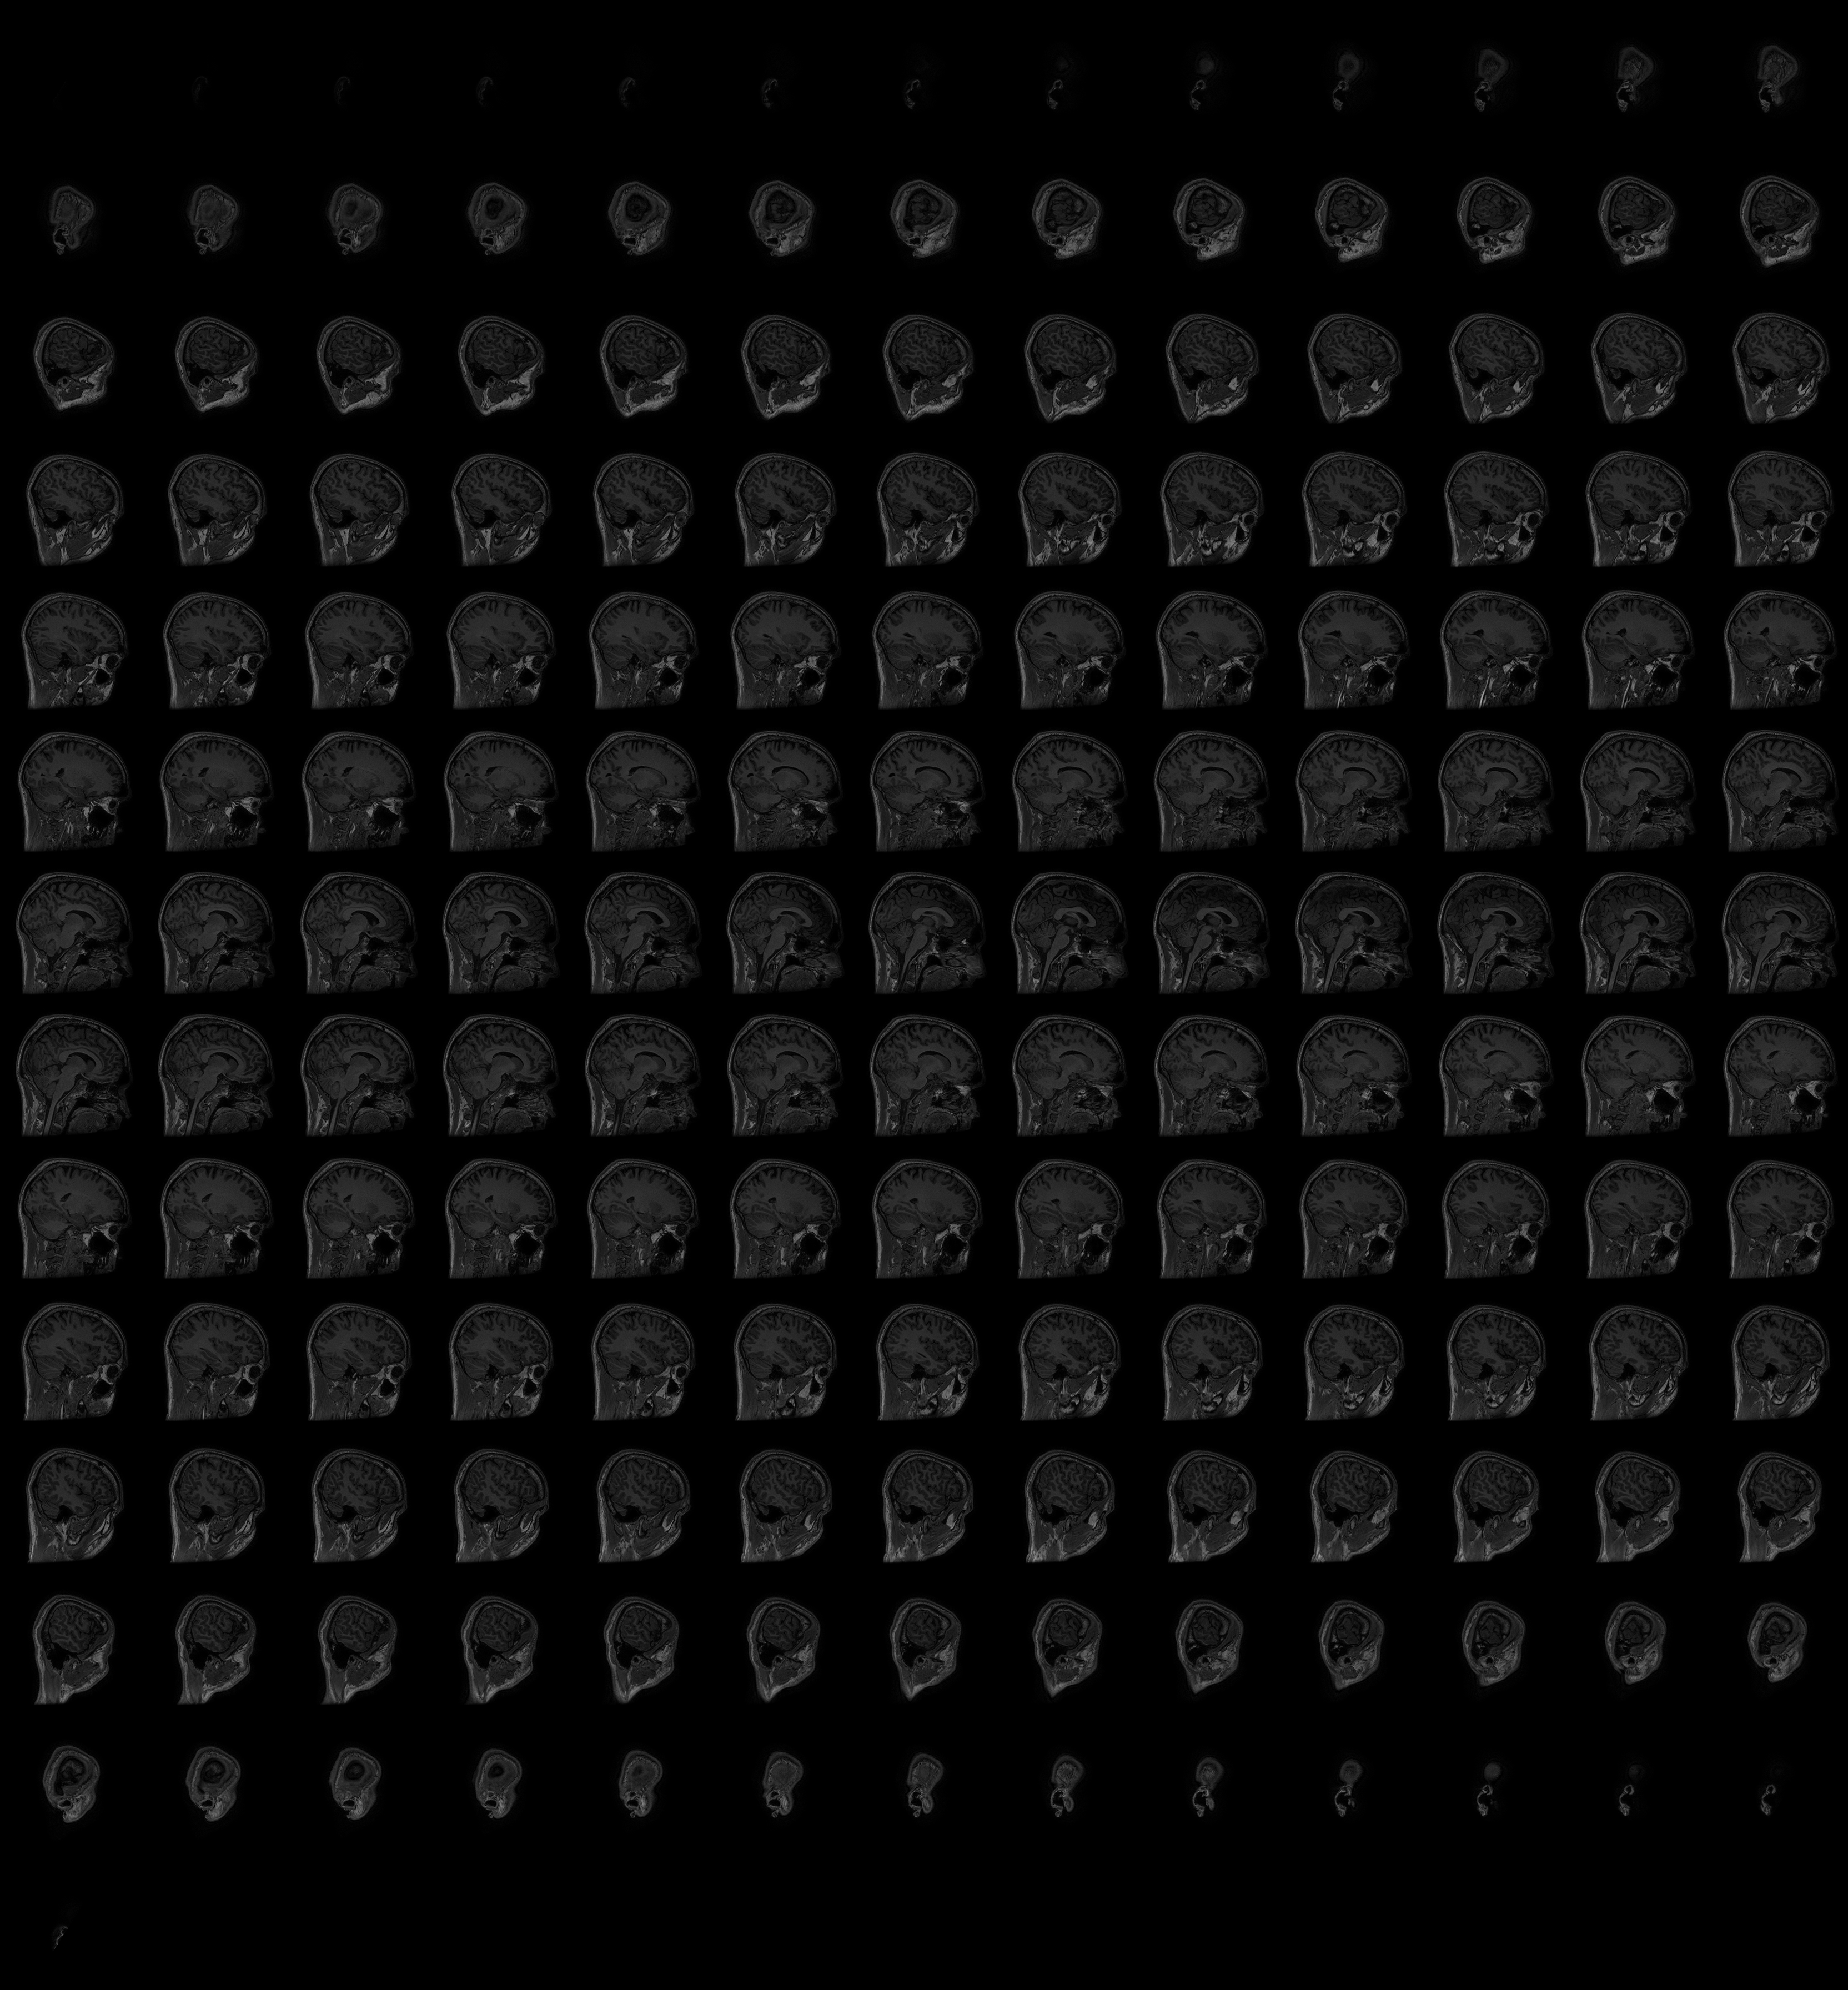
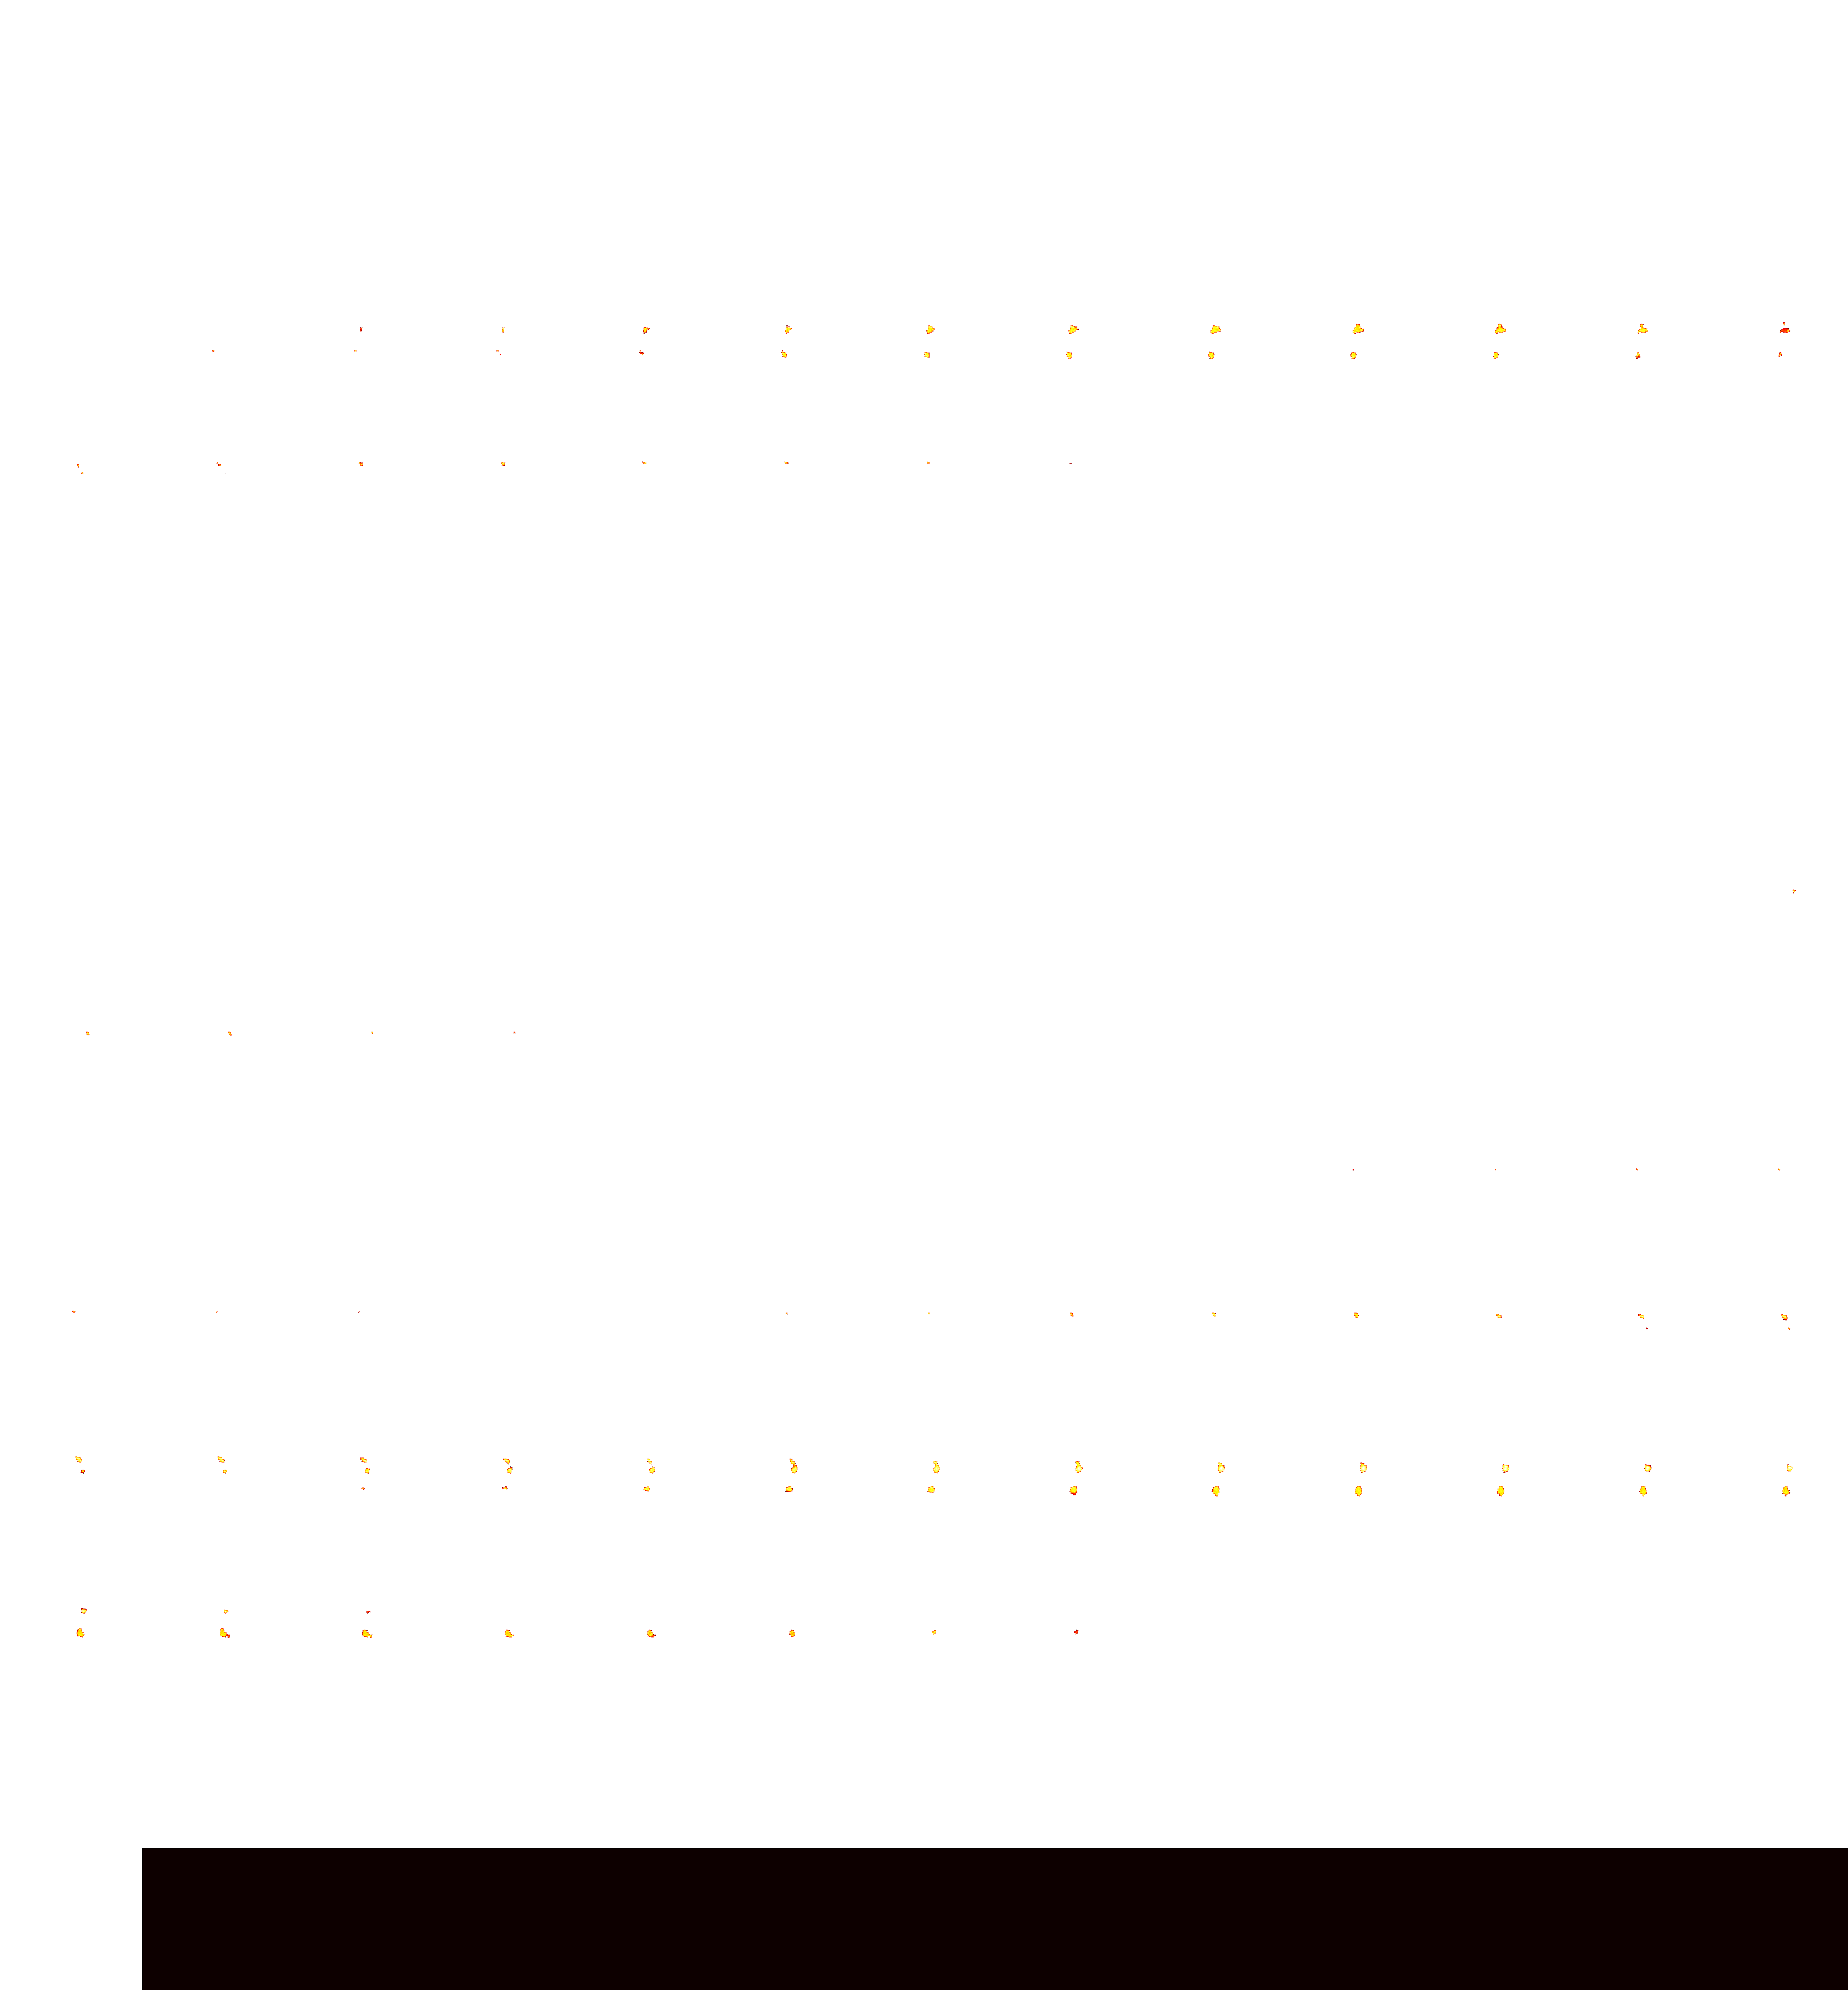

In [39]:
view_img(stat_map_img=fmri, bg_img=t1_resampled, opacity=0.7)

Ну че-то хз. У меня такое чувство, что мы нашли не зону Вернике, а первичную слуховую кору. 

Теперь надо нарисовать участки активации на срезах Т1 и экспортировать все это в DICOM.

In [41]:
#Я умножаю карту активаций на тысячу, чтобы ее было видно на фоне Т1. 
combo = t1_resampled_array + fmri_resampled_array * 1000

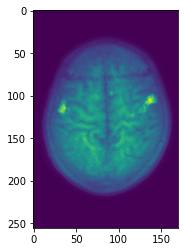

In [42]:
plt.imshow(combo[:,-90:-40,:].mean(axis=1))

Экспорт реализован через SimpleITK. Просто берем сырой срез Т1, берем из него метаданные, пиксельную матрицу подставляем из только что сделанного размеченного Т1, и записываем это в файл.  

In [43]:
!pip install simpleitk tqdm -q

In [44]:
import SimpleITK as sitk
from tqdm import tqdm

In [45]:
series_IDs =  sitk.ImageSeriesReader().GetGDCMSeriesIDs('t1_dicom')
series_file_names =  sitk.ImageSeriesReader().GetGDCMSeriesFileNames('t1_dicom', series_IDs[0])

In [46]:
image_reader = sitk.ImageFileReader()
image_reader.LoadPrivateTagsOn()
image_list = []
for file_name in series_file_names:
    image_reader.SetFileName(file_name)
    image_list.append(image_reader.Execute())

In [47]:
sitk_t1 = sitk.GetImageFromArray(combo)

sitk_t1.SetDirection(image_list[0].GetDirection())

writer = sitk.ImageFileWriter()
writer.KeepOriginalImageUIDOn()

modification_time = time.strftime("%H%M%S")
modification_date = time.strftime("%Y%m%d")

In [48]:
mkdir mapped

mkdir: cannot create directory ‘mapped’: File exists


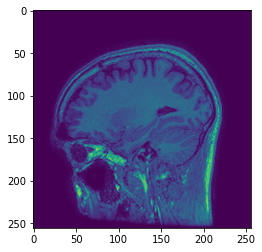

In [49]:
plt.imshow(sitk.GetArrayFromImage(sitk_t1[::,::-1,::][60,:,:]).T)

In [50]:
for i in tqdm(range(len(image_list))):
    #Да, мне стыдно за такой костыль, отстаньте.  
    image_slice = sitk.GetArrayFromImage(sitk_t1[::,::-1,::][i,:,:]).T
    image_slice = sitk.GetImageFromArray(image_slice)
    original_slice = image_list[i]
    
    for k in original_slice.GetMetaDataKeys():
        #if k!="0028|1052" and k!= "0028|1053":
            image_slice.SetMetaData(k, original_slice.GetMetaData(k))

    
    image_slice.SetMetaData("0010|0010", "Modified name, contrast 2")
    image_slice.SetMetaData("0010|0020", "Modified ID")
    image_slice.SetMetaData("0020|000e", "Mapped "+modification_date+".1"+modification_time)
    
    writer.SetFileName('mapped/' + os.listdir('t1_dicom')[i])
    writer.Execute(image_slice)
print('Всё.')

100%|██████████| 170/170 [00:06<00:00, 24.58it/s]

Всё.


In [52]:
print("Все произошло за %.2f минуты." % ((time.time() - start_time)/60))

Все произошло за 13.69 минуты.
